In [1]:
import warnings

warnings.filterwarnings("ignore")

import pyspark.sql
import pyspark.sql.functions as F

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

spark = pyspark.sql.SparkSession.builder.getOrCreate()

def display(spark_df, rows=3):
    return spark_df.limit(rows).toPandas()

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/05/20 17:11:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/05/20 17:11:54 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
case = spark.read.csv('case.csv', 
                       sep=',', 
                       header=True, 
                       inferSchema=True)

dept = spark.read.csv('dept.csv', 
                       sep=',', 
                       header=True, 
                       inferSchema=True)

source = spark.read.csv('source.csv', 
                         sep=',', 
                         header=True,
                         inferSchema=True)

fmt = 'M/d/yy H:mm'

case = (
    case.withColumn('case_id', case.case_id.cast('string'))
        .withColumn('case_opened_date', F.to_timestamp('case_opened_date', fmt))
        .withColumn('case_closed_date', F.to_timestamp('case_closed_date', fmt))
        .withColumnRenamed('SLA_due_date', 'case_due_date')
        .withColumn('case_due_date', F.to_timestamp('case_due_date', fmt))
        .withColumn('case_closed', F.expr('case_closed == "YES"'))
        .withColumn('case_late', F.expr('case_late == "YES"'))
        .withColumn('council_district', case.council_district.cast('string'))
        .withColumn('case_age', F.datediff(F.current_timestamp(), 'case_opened_date'))
        .withColumn('days_to_closed', F.datediff('case_closed_date', 'case_opened_date'))
        .withColumn('case_lifetime', F.when(F.expr('! case_closed'), F.col('case_age'))
                                      .otherwise(F.col('days_to_closed')))
)  

df = (
    case.join(source, on='source_id', how='left')
        .join(dept, on='dept_division', how='left')
        .drop('dept_name')
        .withColumnRenamed('standardized_dept_name', 'department')
        .withColumn('dept_subject_to_SLA', (F.col('dept_subject_to_SLA') == 'YES'))
)

#### 1. How many different cases are there, by department?

In [3]:
df.groupby('department').count().toPandas()

,department,count
0,Solid Waste,286287
1,Animal Care Services,119362
2,Trans & Cap Improvements,97841
3,Parks & Recreation,19964
4,Customer Service,2889
5,Metro Health,5313
6,City Council,34
7,DSD/Code Enforcement,323579


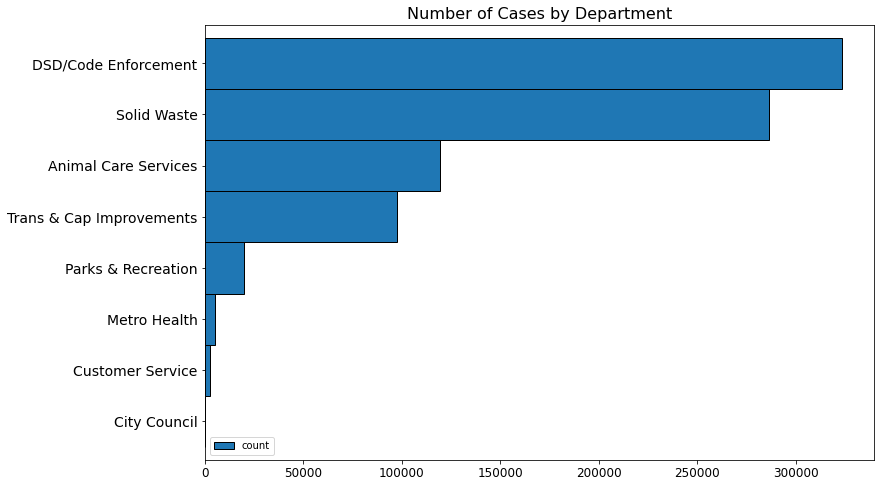

In [4]:
(
    df.groupby('department')
      .count()
      .toPandas()
      .set_index('department')
      .sort_values('count')
      .plot.barh(width=1, edgecolor='black', figsize=(12,8))
)

plt.title('Number of Cases by Department', fontsize=16)
plt.ylabel(None)
plt.xlabel(None)
plt.yticks(fontsize=14)
plt.xticks(fontsize=12)
plt.show()

#### 2. Does the percentage of cases that are late vary by department?

In [5]:
df_2 = (
        df.groupby('department')
          .count()
          .withColumnRenamed('count', 'n_cases')
        )
df_3 = (
        df.filter(F.col('case_late'))
          .groupby('department')
          .count()
          .withColumnRenamed('count', 'n_cases_late')
        )
df_4 = df_2.join(df_3, on='department', how='outer').fillna(0)
df_4 = df_4.withColumn('pct_late', F.round((F.col('n_cases_late') / F.col('n_cases'))*100, 0)).toPandas()
df_4

,department,n_cases,n_cases_late,pct_late
0,Animal Care Services,119362,23751,20.0
1,City Council,34,0,0.0
2,Customer Service,2889,2035,70.0
3,DSD/Code Enforcement,323579,26439,8.0
4,Metro Health,5313,854,16.0
5,Parks & Recreation,19964,3810,19.0
6,Solid Waste,286287,33729,12.0
7,Trans & Cap Improvements,97841,5529,6.0


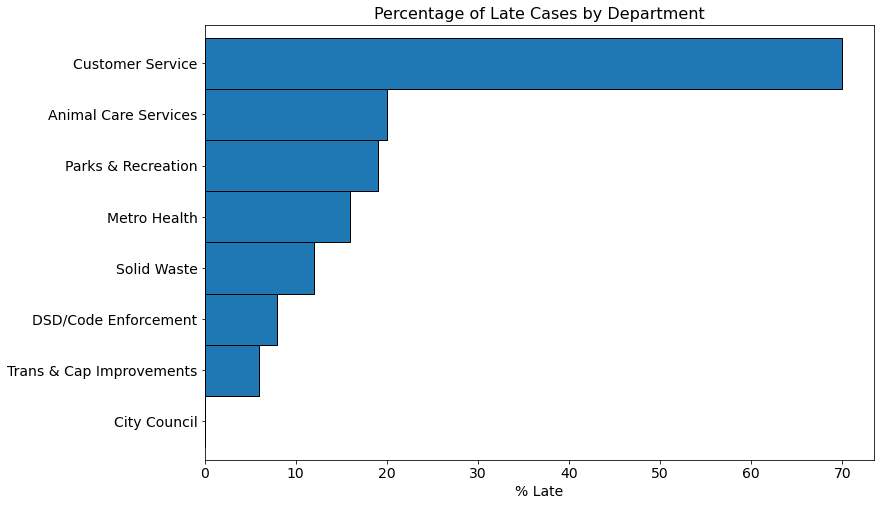

In [6]:
(
    df_4[['department', 'pct_late']]
    .set_index('department')
    .sort_values('pct_late')
    .plot.barh(width=1, 
               ec='black', 
               figsize=(12,8), 
               legend=None)
)
plt.title('Percentage of Late Cases by Department', fontsize=16)
plt.xlabel('% Late', fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel(None)
plt.yticks(fontsize=14)
plt.show()

In [7]:
display(df)

,dept_division,source_id,case_id,case_opened_date,case_closed_date,case_due_date,case_late,num_days_late,case_closed,service_request_type,SLA_days,case_status,request_address,council_district,case_age,days_to_closed,case_lifetime,source_username,department,dept_subject_to_SLA
0,Field Operations,svcCRMLS,1014127332,2018-01-01 00:42:00,2018-01-01 12:29:00,2020-09-26 00:42:00,False,-998.508762,True,Stray Animal,999.000000,Closed,"2315 EL PASO ST, San Antonio, 78207",5,1600,0,0,svcCRMLS,Animal Care Services,True
1,Storm Water,svcCRMSS,1014127333,2018-01-01 00:46:00,2018-01-03 08:11:00,2018-01-05 08:30:00,False,-2.012604,True,Removal Of Obstruction,4.322222,Closed,"2215 GOLIAD RD, San Antonio, 78223",3,1600,2,2,svcCRMSS,Trans & Cap Improvements,True
2,Storm Water,svcCRMSS,1014127334,2018-01-01 00:48:00,2018-01-02 07:57:00,2018-01-05 08:30:00,False,-3.022338,True,Removal Of Obstruction,4.320729,Closed,"102 PALFREY ST W, San Antonio, 78223",3,1600,1,1,svcCRMSS,Trans & Cap Improvements,True


22/05/20 19:24:34 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 1626869 ms exceeds timeout 120000 ms
22/05/20 19:24:34 WARN SparkContext: Killing executors is not supported by current scheduler.


#### 3. On average, how late are the late cases by department?

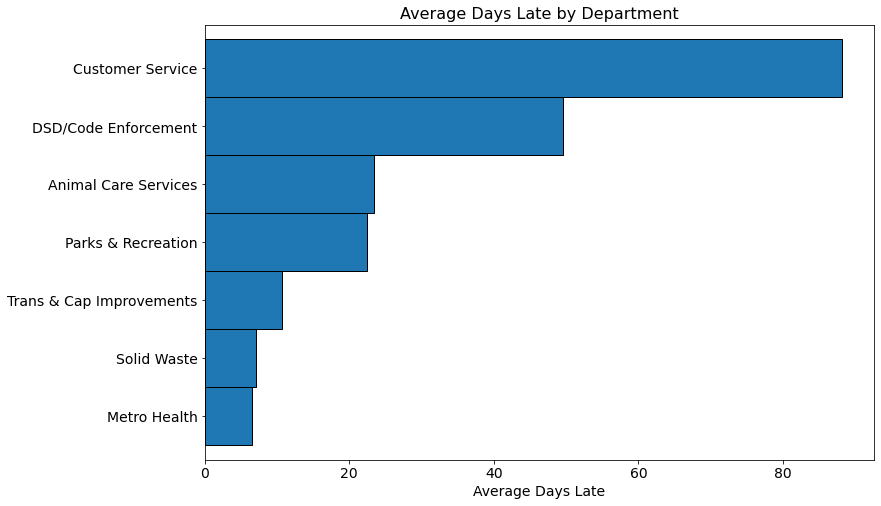

In [27]:
(
    df.filter(F.col('case_late'))
      .groupby('department')
      .agg(F.mean('num_days_late'))
      .toPandas()
      .set_index('department')
      .sort_values('avg(num_days_late)')
      .plot.barh(width=1, ec='black', figsize=(12,8), legend=None)
)
plt.title('Average Days Late by Department', fontsize=16)
plt.ylabel(None)
plt.yticks(fontsize=14)
plt.xlabel('Average Days Late', fontsize=14)
plt.xticks(fontsize=14)
plt.show()

#### 4. What is the service type that is the most late? Just for Parks & Rec?

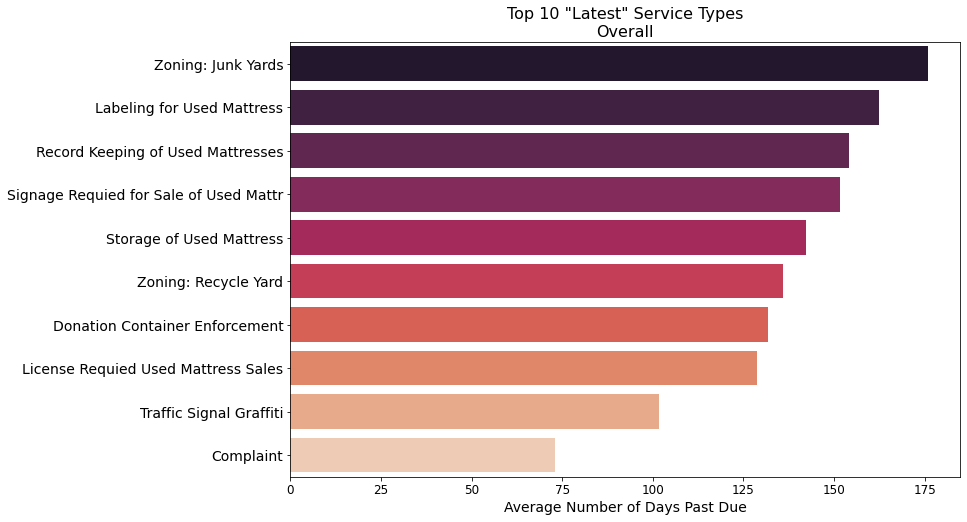

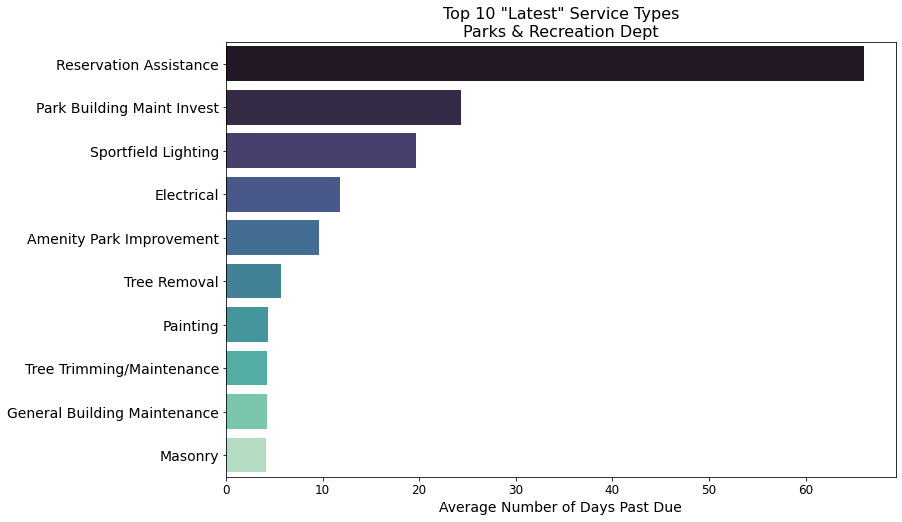

In [66]:
# Overall
plt.figure(figsize=(12,8))
sns.barplot(
    data=df.groupby('service_request_type')
           .agg(F.mean('num_days_late'))
           .toPandas()
           .sort_values('avg(num_days_late)', ascending=False)
           .head(10),
    y='service_request_type',
    x='avg(num_days_late)',
    palette='rocket', 
    orient='h'
)
plt.title('Top 10 "Latest" Service Types\nOverall', fontsize=16)
plt.ylabel(None)
plt.yticks(fontsize=14)
plt.xlabel('Average Number of Days Past Due', fontsize=14)
plt.xticks(fontsize=12)
plt.show()

# Parks and Rec Dept
plt.figure(figsize=(12,8))
sns.barplot(
    data=df.filter(F.col('department') == 'Parks & Recreation')
           .groupby('service_request_type')
           .agg(F.mean('num_days_late'))
           .toPandas()
           .sort_values('avg(num_days_late)', ascending=False)
           .head(10),
    y='service_request_type',
    x='avg(num_days_late)',
    palette='mako', 
    orient='h'
)
plt.title('Top 10 "Latest" Service Types\nParks & Recreation Dept', fontsize=16)
plt.ylabel(None)
plt.yticks(fontsize=14)
plt.xlabel('Average Number of Days Past Due', fontsize=14)
plt.xticks(fontsize=12)
plt.show()

#### 5. For the DSD/Code Enforcement department, what are the most common service request types? Look at other departments too.

#### 6. Does whether or not its a weekend matter for when a case is opened/closed?

#### 7. On average, how many cases are opened a day for the Customer Service department?

#### 8. Does the number of service requests for the solid waste department vary by day of the week?